# Train U-Net
This file tests U-Net. Data from 00_Data_Preprocessed in splited and augmented, the used as training data for a pre-trained U-Net.

In [4]:
!pip install segmentation-models-pytorch
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip utils
!unzip preprocess
!unzip 00_Data_Preprocessed

In [1]:
import os
import time 
import json
import numpy as np
from glob import glob
import re
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv2
import time
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm,tnrange
import segmentation_models_pytorch as smp
from utils import vis_utils,data_utils,eval_utils
from utils.model_utils import eval_model,train_Unet
from torchmetrics import JaccardIndex,F1Score
from utils.preprocess_utils import split_w_overlap, augmentDataset, flip, rotate
from preprocess.preparedata_01 import split_transform_all

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
device

device(type='cuda', index=0)

### 1) Import raw data, split into subimages and augment
import big complete hillshade, dtm and label, split with overlap and apply flip and rotation transformation. At the end of the this step, each site has a list of sub dtms, sub hillsahde and sub label images. The augmented subimages data is stored in a dictionary

In [2]:

root_path = os.path.abspath(os.path.join(os.getcwd(),"../")) #github
root_path = os.path.abspath(os.getcwd()) # colab
raw_data = os.path.join(root_path,"00_Data_Preprocessed")

tifs = glob(os.path.join(raw_data,"*.tif"))
# get all the dtm, labels and hillshade files underneath 00_Data_Preprocessed
dtms_path_all = list(filter(re.compile(".*dtm.tif$").search,tifs))
labels_path_all = list(filter(re.compile(".*label.tif$").search,tifs))
hsds_path_all = list(filter(re.compile(".*\\d+_\\d+.*.tif$").search,tifs))

subimage_size =512
overlap = 64

#site_list = ["ardmayle","kilbixy","knockainey"]
transform_list = [flip("horizontal"), flip("veritical"),rotate(90),rotate(180),rotate(270)]
transform_name_list = ["hoflip","verflip","rot90","rot180","rot270"]
data_preprocessed_dict = split_transform_all(dtms_path_all,labels_path_all,hsds_path_all,
                                        transform_list,transform_name_list,
                                        chipsize = subimage_size, overlap = overlap,
                                        write=False,vis=False)

Processing kilbixy ...


spliting kilbixy into 260 subimages: 100%|██████████| 20/20 [00:00<00:00, 40156.09it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 260/260 [00:00<00:00, 396408.23it/s]
applying hoflip, saving transformed images and labels: 100%|██████████| 260/260 [00:00<00:00, 44172.03it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 260/260 [00:00<00:00, 304019.80it/s]
applying verflip, saving transformed images and labels: 100%|██████████| 260/260 [00:00<00:00, 44000.93it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 260/260 [00:00<00:00, 436382.17it/s]
applying rot90, saving transformed images and labels: 100%|██████████| 260/260 [00:00<00:00, 16298.05it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 260/260 [00:00<00:00, 246389.30it/s]
applying rot180, saving transformed images and labels: 100%|██████████| 260/260 [00:00<0

Processing knockainey ...


spliting knockainey into 216 subimages: 100%|██████████| 18/18 [00:00<00:00, 3437.80it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 216/216 [00:00<00:00, 390841.10it/s]
applying hoflip, saving transformed images and labels: 100%|██████████| 216/216 [00:00<00:00, 40522.86it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 216/216 [00:00<00:00, 273046.92it/s]
applying verflip, saving transformed images and labels: 100%|██████████| 216/216 [00:00<00:00, 53462.15it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 216/216 [00:00<00:00, 421970.03it/s]
applying rot90, saving transformed images and labels: 100%|██████████| 216/216 [00:00<00:00, 17933.60it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 216/216 [00:00<00:00, 267563.40it/s]
applying rot180, saving transformed images and labels: 100%|██████████| 216/216 [00:00

Processing ardmayle ...


spliting ardmayle into 35 subimages: 100%|██████████| 5/5 [00:00<00:00, 21013.55it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 35/35 [00:00<00:00, 152758.21it/s]
applying hoflip, saving transformed images and labels: 100%|██████████| 35/35 [00:00<00:00, 44566.07it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 35/35 [00:00<00:00, 146361.56it/s]
applying verflip, saving transformed images and labels: 100%|██████████| 35/35 [00:00<00:00, 48803.40it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 35/35 [00:00<00:00, 177940.17it/s]
applying rot90, saving transformed images and labels: 100%|██████████| 35/35 [00:00<00:00, 19835.24it/s]
adding original sub hillshade images, its corresponding label and dtm: 100%|██████████| 35/35 [00:00<00:00, 127763.83it/s]
applying rot180, saving transformed images and labels: 100%|██████████| 35/35 [00:00<00:00, 9462.46it/s]

### 2) Make training, validation and testing dataset.
First, unpack the dictionary data from last step. Using site name to grab its corresponding sub dtm, hillshade and label images. Prepare training and testing separately, then make train-val split on training set. Pad subimages to match the same sub image dimension and grayscale to RGB transformation is also applied. Storing data utilized the HELMDataset class object defined in utils.data_utils. This makes using pytorch for training and evaluation easier.

In [3]:
def unpack_dict(data_preprocessed_dict,sitelist):
    subdtms = []
    subhsds = []
    sublabels  = []
    coord_list = []
    for site in sitelist:
        subdtms.extend(data_preprocessed_dict[site]['dtm'])
        subhsds.extend(data_preprocessed_dict[site]['hsd'])
        sublabels.extend(data_preprocessed_dict[site]['label'])
        coord_list.extend(data_preprocessed_dict[site]['coord_list'])
    return subdtms,subhsds,sublabels,coord_list
        

In [4]:
trainSites=['ardmayle','kilbixy']
testSites = ['knockainey']
chip_size  = 512
train_prop = 0.8
seed = 42
num_classes = 2
batch_size = 10
use_hillshade = True
drop_edge = True


# duplicate the channel gray scale image 2 times -> 3 channel img
gray2rgb_transform = transforms.Compose([data_utils.gray2rgb])
pad_transform = transforms.Compose([
        transforms.ToTensor(),
        data_utils.pad4sides((chip_size,chip_size))])

# get training data based on trainiing site name(s)
subdtms_train,subhsds_train,sublabels_train,coordlist_train = unpack_dict(data_preprocessed_dict,trainSites)
trainValDataset =  data_utils.HELMDataset(subdtm_arrays=subdtms_train,subhsd_arrays=subhsds_train,
                                        sublabel_arrays=sublabels_train,coord_list=coordlist_train,
                                        use_hillshade = use_hillshade,drop_edge =drop_edge, size = chip_size,
                                        transform=gray2rgb_transform,pad_transform=pad_transform)
print("Train val set sample size:",len(trainValDataset))
# do train and val split
train_set,val_set = data_utils.split_data(trainValDataset,train_prop,seed =seed)

# get test data based on test site name(s)
subdtms_test,subhsds_test,sublabels_test,coordlist_test = unpack_dict(data_preprocessed_dict,testSites)
test_set =  data_utils.HELMDataset(subdtm_arrays=subdtms_test,subhsd_arrays=subhsds_test,
                                        sublabel_arrays=sublabels_test,coord_list=coordlist_test,
                                        use_hillshade = use_hillshade,drop_edge =drop_edge, size = chip_size,
                                        transform=gray2rgb_transform,pad_transform=pad_transform)
print("Test set sample size:",len(trainValDataset))

adding hillshade and label: 100%|██████████| 1770/1770 [00:00<00:00, 293586.35it/s]


Train val set sample size: 1512
train:test = 1210:302


adding hillshade and label: 100%|██████████| 1296/1296 [00:00<00:00, 206034.87it/s]

Test set sample size: 1512


#### visualize a few examples

In [5]:
def visualize(dtm_tensor=None,hsd_tensor=None, gt_mask_tensor=None,pred_mask_tensor=None,
                  plot_titles = ['dtm','hillshade','ground truth','prediction']):

    """
    visualize a sample, which type of image to plot is optional
    """
    tensor2img = torchvision.transforms.ToPILImage()
    plot_list = [dtm_tensor,hsd_tensor,gt_mask_tensor,pred_mask_tensor]
    plot_list = [i for i in plot_list if (not i is None)]

    fig,ax = plt.subplots(1,len(plot_list),figsize=(len(plot_list)*5,5))
    for i  in range(len(plot_list)):
        if plot_list[i].shape[0] == 3:
          plot_tensor = tensor2img(plot_list[i])
        else:
          plot_tensor = plot_list[i].squeeze(0)
        if plot_titles[i] == "image" or plot_titles[i] == "hillshade" :
            ax[i].imshow(plot_tensor,cmap='gray')
        else:
            ax[i].imshow(plot_tensor)
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        ax[i].set_title(plot_titles[i],fontsize=16)
    
    return fig

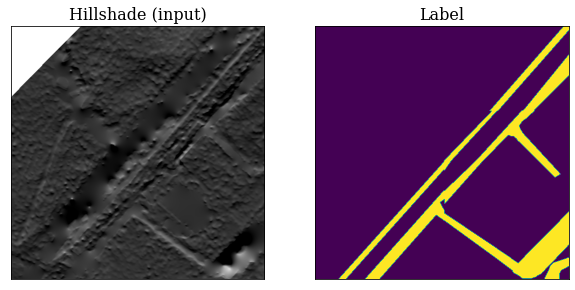

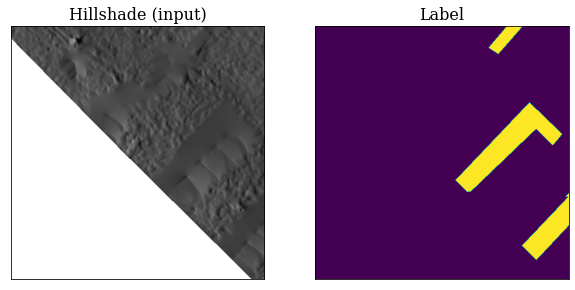

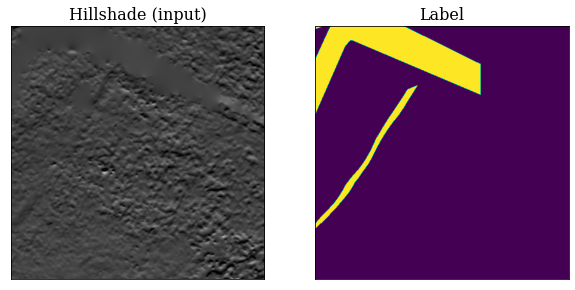

In [6]:
for i in range(3):
  X,y = train_set[np.random.randint(0,len(train_set))]
  fig = visualize(X,y,plot_titles=["Hillshade (input)","Label"])

### 3) Load U-Net architecture and pretrained weight, train

3.1 Load Unet Model and encoder weights pre-trained on ImageNet from https://segmentation-modelspytorch.readthedocs.io/en/latest/.
Then train on train_set, evaluate the model on validation set at the same time. Use binary dice loss function.

3.2 load the train and validation data, then train. Save model weights to `./model_weights`

In [12]:
UnetVGG16 = smp.Unet('vgg16',classes=1,encoder_weights='imagenet',activation = "sigmoid")
params_encoder = sum(p.numel() for p in UnetVGG16 ._modules['encoder'].parameters())
print("Number of parameters in Encoder block: %d"%params_encoder)
params_encoder = sum(p.numel() for p in UnetVGG16 ._modules['decoder'].parameters())
print("Number of parameters in decoder block: %d"%params_encoder)
params_encoder = sum(p.numel() for p in UnetVGG16 ._modules['segmentation_head'].parameters())
print("Number of parameters in segmentation head: %d"%params_encoder)

Number of parameters in Encoder block: 14714688
Number of parameters in decoder block: 9033408
Number of parameters in segmentation head: 145


In [13]:
# define and create the folder to save trained weights
model_folder = os.path.join(root_path,"model/models_weights_temp")
os.makedirs(model_folder,exist_ok=True)

# load training and validation data with Pytorch Dataloader, this retrive samples by batch, for smaller computational memory
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, sampler=None,)
validloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, sampler=None,)

In [16]:
# adjustable arguments when calling the train function
model = UnetVGG16
model_name = "Dice_train_ard_kilb"
lr = 0.0007
momentum = 0.8
epochs = 35
batch_size = 10
freeze_encoder = False
load_weights = False
num_classes = 2
use_hillshade= True
thresh = 0.4 # subjective to change, just for evaluation to print out something

# declare pytorch optimizer
optimizer = torch.optim.SGD(params=model.parameters(),lr=lr, momentum=momentum)
criterion = smp.utils.losses.DiceLoss() 

# call tran_Unet to start the training process
start_time = time.time()
model,train_epoch_loss,train_epoch_iou,val_epoch_loss,val_epoch_iou = train_Unet(
      model,model_name,trainloader,num_classes,
      criterion,optimizer,epochs,thresh,device,validloader)
end_time = time.time()
print("Finished training, total time: %.3fmin"%((end_time-start_time)/60))

# save trained model
lr_str = '{:.0e}'.format(lr)
momentum_str = '{:.0e}'.format(momentum)
weights_filename = f"Unet{model_name}_{epochs}ep{lr_str}lr{batch_size}b{momentum_str}m"

weights_file= weights_filename  +".pth"
modelpath = os.path.join(model_folder, weights_file)
torch.save(model, modelpath)

# save train progress
train_progress = dict({"train_loss": train_epoch_loss,
                  "train_mIoU": train_epoch_iou,
                  "val_loss": val_epoch_loss, 
                  "val_iou": val_epoch_iou})
progressfilename = f"{weights_filename}_progress.json"
progressfilepath = os.path.join(model_folder,progressfilename)
with open(progressfilepath, "w") as f:
    json.dump(train_progress, f, indent=4)


Evaluating: 100%|██████████| 31/31 [00:13<00:00,  2.23batch/s, loss=0.725, meanIoU=0.354]


Epoch train loss = 0.794, train mIoU = 0.326, validation loss = 0.789, mIoU = 0.340 


Evaluating: 100%|██████████| 31/31 [00:13<00:00,  2.22batch/s, loss=0.713, meanIoU=0.403]


Epoch train loss = 0.779, train mIoU = 0.367, validation loss = 0.771, mIoU = 0.404 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.21batch/s, loss=0.695, meanIoU=0.451]


Epoch train loss = 0.762, train mIoU = 0.413, validation loss = 0.748, mIoU = 0.464 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.21batch/s, loss=0.675, meanIoU=0.467]


Epoch train loss = 0.737, train mIoU = 0.462, validation loss = 0.728, mIoU = 0.484 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.20batch/s, loss=0.653, meanIoU=0.512]


Epoch train loss = 0.708, train mIoU = 0.502, validation loss = 0.693, mIoU = 0.533 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.19batch/s, loss=0.615, meanIoU=0.538]


Epoch train loss = 0.676, train mIoU = 0.532, validation loss = 0.655, mIoU = 0.554 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.19batch/s, loss=0.603, meanIoU=0.564]


Epoch train loss = 0.647, train mIoU = 0.553, validation loss = 0.625, mIoU = 0.580 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.589, meanIoU=0.573]


Epoch train loss = 0.618, train mIoU = 0.571, validation loss = 0.596, mIoU = 0.596 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.561, meanIoU=0.585]


Epoch train loss = 0.592, train mIoU = 0.586, validation loss = 0.569, mIoU = 0.608 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.54, meanIoU=0.595]


Epoch train loss = 0.570, train mIoU = 0.599, validation loss = 0.553, mIoU = 0.613 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.529, meanIoU=0.604]


Epoch train loss = 0.545, train mIoU = 0.613, validation loss = 0.534, mIoU = 0.622 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.565, meanIoU=0.588]


Epoch train loss = 0.527, train mIoU = 0.623, validation loss = 0.516, mIoU = 0.639 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.17batch/s, loss=0.508, meanIoU=0.616]


Epoch train loss = 0.513, train mIoU = 0.630, validation loss = 0.517, mIoU = 0.628 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.542, meanIoU=0.598]


Epoch train loss = 0.498, train mIoU = 0.638, validation loss = 0.497, mIoU = 0.643 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.481, meanIoU=0.626]


Epoch train loss = 0.478, train mIoU = 0.646, validation loss = 0.495, mIoU = 0.634 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.17batch/s, loss=0.558, meanIoU=0.591]


Epoch train loss = 0.470, train mIoU = 0.651, validation loss = 0.477, mIoU = 0.649 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.17batch/s, loss=0.591, meanIoU=0.578]


Epoch train loss = 0.458, train mIoU = 0.657, validation loss = 0.493, mIoU = 0.645 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.568, meanIoU=0.587]


Epoch train loss = 0.446, train mIoU = 0.663, validation loss = 0.479, mIoU = 0.654 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.49, meanIoU=0.624]


Epoch train loss = 0.443, train mIoU = 0.665, validation loss = 0.456, mIoU = 0.658 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.504, meanIoU=0.616]


Epoch train loss = 0.432, train mIoU = 0.672, validation loss = 0.456, mIoU = 0.659 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.17batch/s, loss=0.506, meanIoU=0.615]


Epoch train loss = 0.425, train mIoU = 0.675, validation loss = 0.451, mIoU = 0.661 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.17batch/s, loss=0.466, meanIoU=0.636]


Epoch train loss = 0.415, train mIoU = 0.680, validation loss = 0.449, mIoU = 0.661 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.17batch/s, loss=0.511, meanIoU=0.614]


Epoch train loss = 0.409, train mIoU = 0.684, validation loss = 0.445, mIoU = 0.664 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.445, meanIoU=0.647]


Epoch train loss = 0.404, train mIoU = 0.687, validation loss = 0.449, mIoU = 0.662 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.606, meanIoU=0.571]


Epoch train loss = 0.398, train mIoU = 0.690, validation loss = 0.470, mIoU = 0.650 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.17batch/s, loss=0.524, meanIoU=0.609]


Epoch train loss = 0.392, train mIoU = 0.694, validation loss = 0.440, mIoU = 0.666 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.49, meanIoU=0.625]


Epoch train loss = 0.379, train mIoU = 0.701, validation loss = 0.442, mIoU = 0.665 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.17batch/s, loss=0.617, meanIoU=0.57]


Epoch train loss = 0.378, train mIoU = 0.702, validation loss = 0.463, mIoU = 0.657 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.567, meanIoU=0.589]


Epoch train loss = 0.367, train mIoU = 0.708, validation loss = 0.438, mIoU = 0.670 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.487, meanIoU=0.624]


Epoch train loss = 0.364, train mIoU = 0.710, validation loss = 0.435, mIoU = 0.668 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.15batch/s, loss=0.542, meanIoU=0.603]


Epoch train loss = 0.363, train mIoU = 0.710, validation loss = 0.452, mIoU = 0.663 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.501, meanIoU=0.62]


Epoch train loss = 0.350, train mIoU = 0.718, validation loss = 0.457, mIoU = 0.657 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.17batch/s, loss=0.545, meanIoU=0.599]


Epoch train loss = 0.350, train mIoU = 0.719, validation loss = 0.434, mIoU = 0.671 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.16batch/s, loss=0.6, meanIoU=0.576]


Epoch train loss = 0.344, train mIoU = 0.723, validation loss = 0.452, mIoU = 0.665 


Evaluating: 100%|██████████| 31/31 [00:14<00:00,  2.18batch/s, loss=0.575, meanIoU=0.589]


Epoch train loss = 0.336, train mIoU = 0.727, validation loss = 0.451, mIoU = 0.665 
Finished training, total time: 94.704min


3.3  Plot training progress: train loss, validation loss, train IoU, and validation IoU

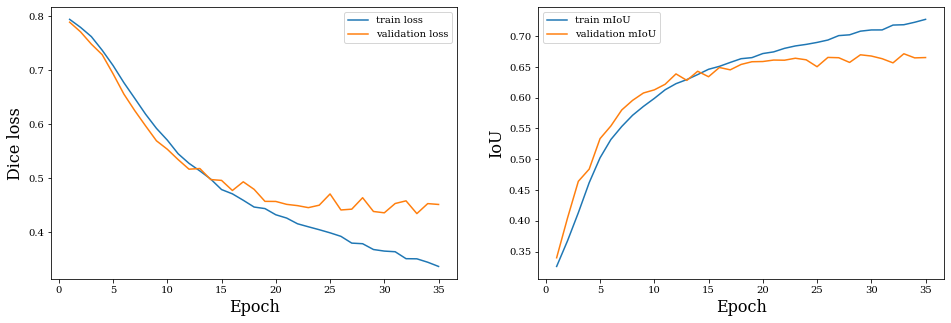

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(np.arange(1,len(train_epoch_loss)+1),train_epoch_loss,label="train loss")
ax[0].plot(np.arange(1,len(train_epoch_loss)+1),val_epoch_loss,label="validation loss")
ax[0].set_xlabel("Epoch",fontsize=16)
ax[0].set_ylabel("Dice loss", fontsize=16)
ax[0].legend()
ax[1].plot(np.arange(1,len(train_epoch_loss)+1),train_epoch_iou,label="train mIoU")
ax[1].plot(np.arange(1,len(train_epoch_loss)+1),val_epoch_iou,label="validation mIoU")
ax[1].set_xlabel("Epoch",fontsize=16)
ax[1].set_ylabel("IoU", fontsize=16)
ax[1].legend()
lr_str = '{:.0e}'.format(lr)
momentum_str = '{:.0e}'.format(momentum)
plotname= f"trainprogress{weights_filename}.png"
#print(os.path.join(models_folder,plotname))
plt.savefig(os.path.join(model_folder,plotname))
plt.show()


In [15]:
# dowload file from colab
from google.colab import files
modelpath = "/content/model/models_weights_temp/UnetDice_train_ard_kilb_35ep7e-04lr10b8e-01m.pth"
# files.download(modelpath)
# files.download(progressfilepath)
# files.download(os.path.join(model_folder,plotname)) 


In [42]:
# clean up GPU memory for CoLab
import gc
gc.collect() 
torch.cuda.empty_cache()

### 4) Test on the test_set
The test used here is augmented. This section plots predictions for a few samples from the test set, and report an IoU and F1 score over the complete augmented test dataset. Applying and more evaluation of the model is in `evaluate_predict/evaluate_predict.ipynb`. The weights, training progress as json file and plot, and predicted probability plot for a few examples of test data are the moved to `02_Results_Weights/{modelname}`.

In [16]:
# load model path
modelweight_path = modelpath
model = torch.load(modelweight_path,map_location=device)
weights_filename = re.findall(r".*(?=\.pth)",os.path.basename(modelweight_path))[0]
print("loading weights of", weights_filename)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, sampler=None,)
criterion = smp.utils.losses.DiceLoss() 
y_prob_list,loss,IoU = eval_model(model,testloader,
                            criterion,num_classes,thresh=0.5,device = device)

loading weights of UnetDice_train_ard_kilb_35ep7e-04lr10b8e-01m


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.17batch/s, loss=0.651, meanIoU=0.58]


compute IoU and F1 score at threshold = 0.5

In [27]:
# reshape the list of y_prob [N H W] where N = number of sample
y_predprob = torch.stack(y_prob_list, dim=0)
# get all ground truthlabel
y = [ pad_transform(sublabel.copy()) for sublabel in test_set.sublabels]
y = torch.stack(y).squeeze(1)

target = torch.Tensor(y).to(device).bool()
pred = torch.Tensor(y_predprob)
Jaccard = JaccardIndex(num_classes=2,threshold=0.5).to(device)
IoU = Jaccard(pred,target)
F1_score = F1Score(num_classes=1,threshold=0.5).to(device)
pred_flatten = torch.flatten(pred,0)
target_flatten = torch.flatten(target,0)
F1 = F1_score(pred_flatten,target_flatten)
print(f"Iou = {round(IoU.item(),4)}, F1 =  {round(F1.item(),4)},")


Iou = 0.446, F1 =  0.0796,


Plot 4 prediction example

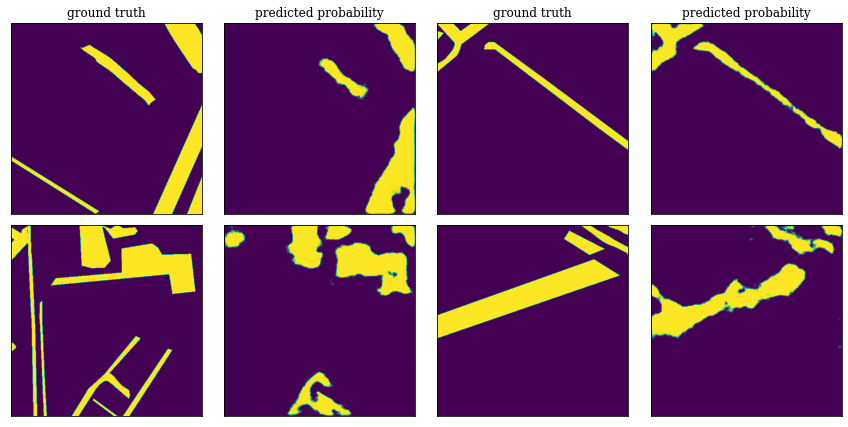

In [32]:
import matplotlib.ticker as ticker
N = 4
fig,ax = plt.subplots(int(N/2),4,figsize=(4*3,N/2*3))
for n in range(N):
  model.eval()
  X,y = train_set[np.random.randint(0,20)]
  y_hat = model(X.unsqueeze(0).to(device))
  row = int(n%(N/2))
  col = int(n//(N/2))
  ax[row][col*2].imshow(y.squeeze(0))
  ax[row][col*2+1].imshow(y_hat.detach().cpu().squeeze(0).squeeze(0).numpy())
  # set axes  off
  ax[row][col*2].xaxis.set_major_locator(ticker.NullLocator())
  ax[row][col*2].yaxis.set_major_locator(ticker.NullLocator())
  ax[row][col*2+1].xaxis.set_major_locator(ticker.NullLocator())
  ax[row][col*2+1].yaxis.set_major_locator(ticker.NullLocator())

ax[0][0].set_title("ground truth")
ax[0][1].set_title("predicted probability")
ax[0][2].set_title("ground truth")
ax[0][3].set_title("predicted probability")
fig.tight_layout() 
fig.savefig(f"{weights_filename}test_predprob.png")

In [34]:
# files.download(f"{weights_filename}test_predprob.png") # if running in Colab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If want to train the model from command line, use trainUnetCLT.py. <br>

```! python trainUnetCLT.py -d /content/00_Data_Preprocessed -train ardmayle kilbixy -test knockainey -use_h -prop 0.8 -s 512 -lr 0.0007 -m 0.8 -e 35 -b 10 -f -o train_ard_kilb```

This would produce the same results as this notebook.

